# EA072 - Inteligência Artificial
# EFC3 - Questão 5 - 1

## Autoencoder training and manifold visualization
## Partially based on https://www.kaggle.com/apapiu/manifold-learning-and-autoencoders

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Rafael Gonçalves

Melhorias (diminuição de neurônios, aumento de épocas de treino e mudança da função de cuso) baseadas em: https://blog.keras.io/building-autoencoders-in-keras.html

### 5.1. Imports

In [1]:
import tensorflow as tf
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

### 5.2. Reading the data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
x_images = x_train.reshape(x_train.shape[0], 28, 28)

In [5]:
# Definition of a function to visualize some digits
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")

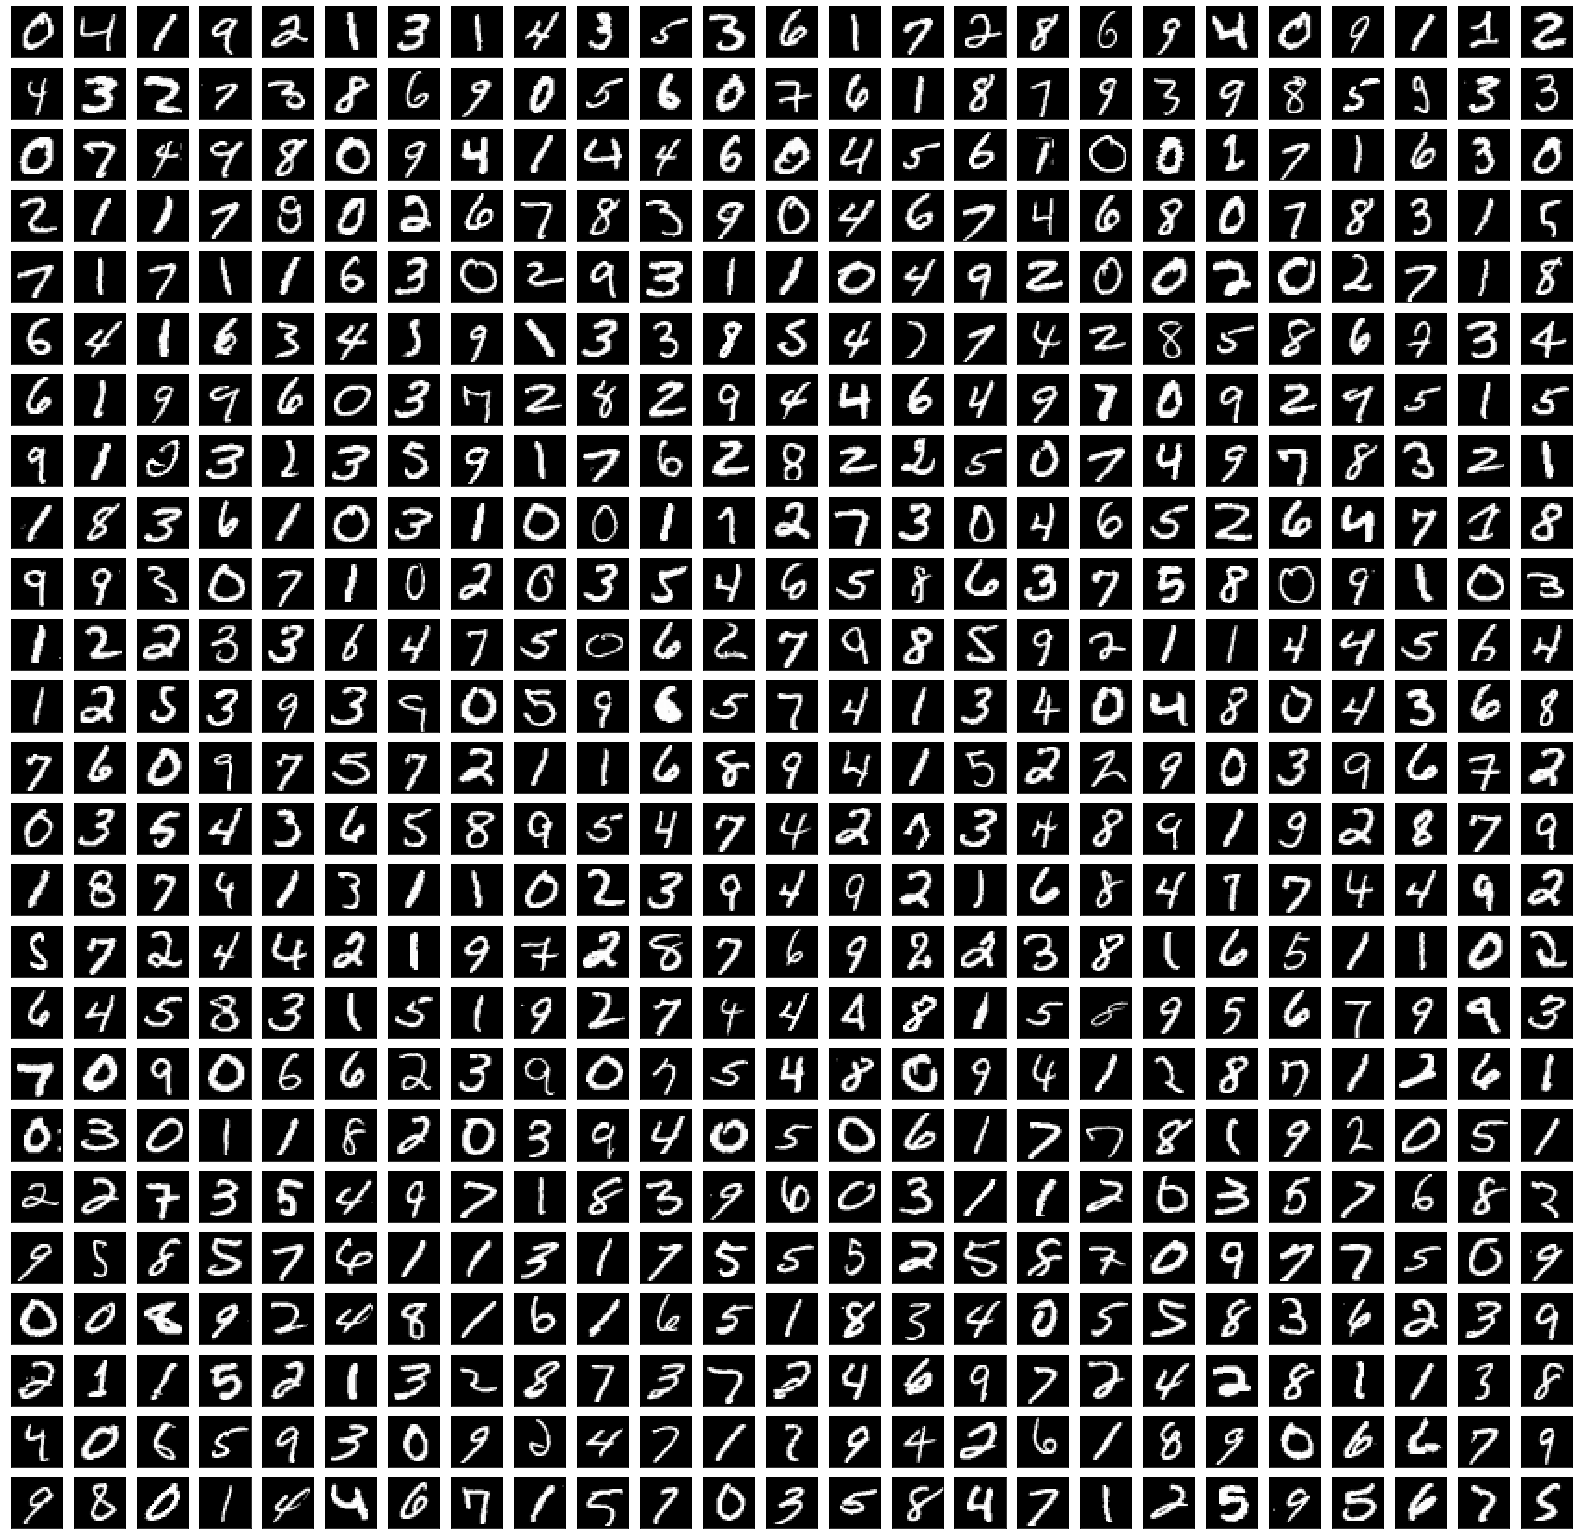

In [6]:
# Visualization of 25 x 25 images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(x_images[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

### 5.3 Proposal for the autoencoder architecture

In [7]:
input_img = Input(shape=(784,))

encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(32, activation='relu')(encoded)

encoded = Dense(2, activity_regularizer=tf.keras.regularizers.l1(10e-6))(encoded) # Linear activation function at the bottleneck

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)

decoded = Dense(784, activation = 'sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

In [8]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
_________________________________________________________________
dense_3 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_5 (Dense)              (None, 784)              

In [9]:
# Cross entropy as loss
autoencoder.compile(optimizer = "adam", loss = "binary_crossentropy")
X = x_train.reshape(x_train.shape[0], 784)
X = x_train.reshape(x_train.shape[0], 784)
history = autoencoder.fit(X, X, batch_size = 512, epochs = 300, verbose = 1, shuffle=True)

Epoch 1/300
118/118 [==============================] - 0s 4ms/step - loss: 0.3163
Epoch 2/300
118/118 [==============================] - 0s 4ms/step - loss: 0.2347
Epoch 3/300
118/118 [==============================] - 0s 4ms/step - loss: 0.2243
Epoch 4/300
118/118 [==============================] - 0s 4ms/step - loss: 0.2152
Epoch 5/300
118/118 [==============================] - 0s 4ms/step - loss: 0.2082
Epoch 6/300
118/118 [==============================] - 1s 4ms/step - loss: 0.2030
Epoch 7/300
118/118 [==============================] - 0s 4ms/step - loss: 0.1995
Epoch 8/300
118/118 [==============================] - 1s 4ms/step - loss: 0.1968
Epoch 9/300
118/118 [==============================] - 0s 4ms/step - loss: 0.1947
Epoch 10/300
118/118 [==============================] - 0s 4ms/step - loss: 0.1930
Epoch 11/300
118/118 [==============================] - 0s 4ms/step - loss: 0.1916
Epoch 12/300
118/118 [==============================] - 0s 4ms/step - loss: 0.1904
Epoch 13/300


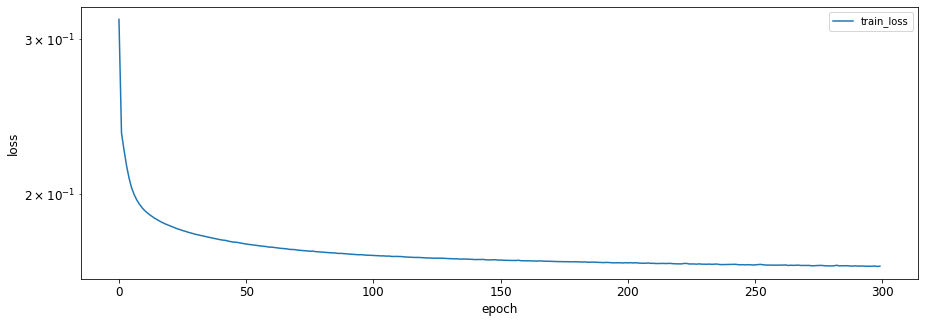

In [10]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

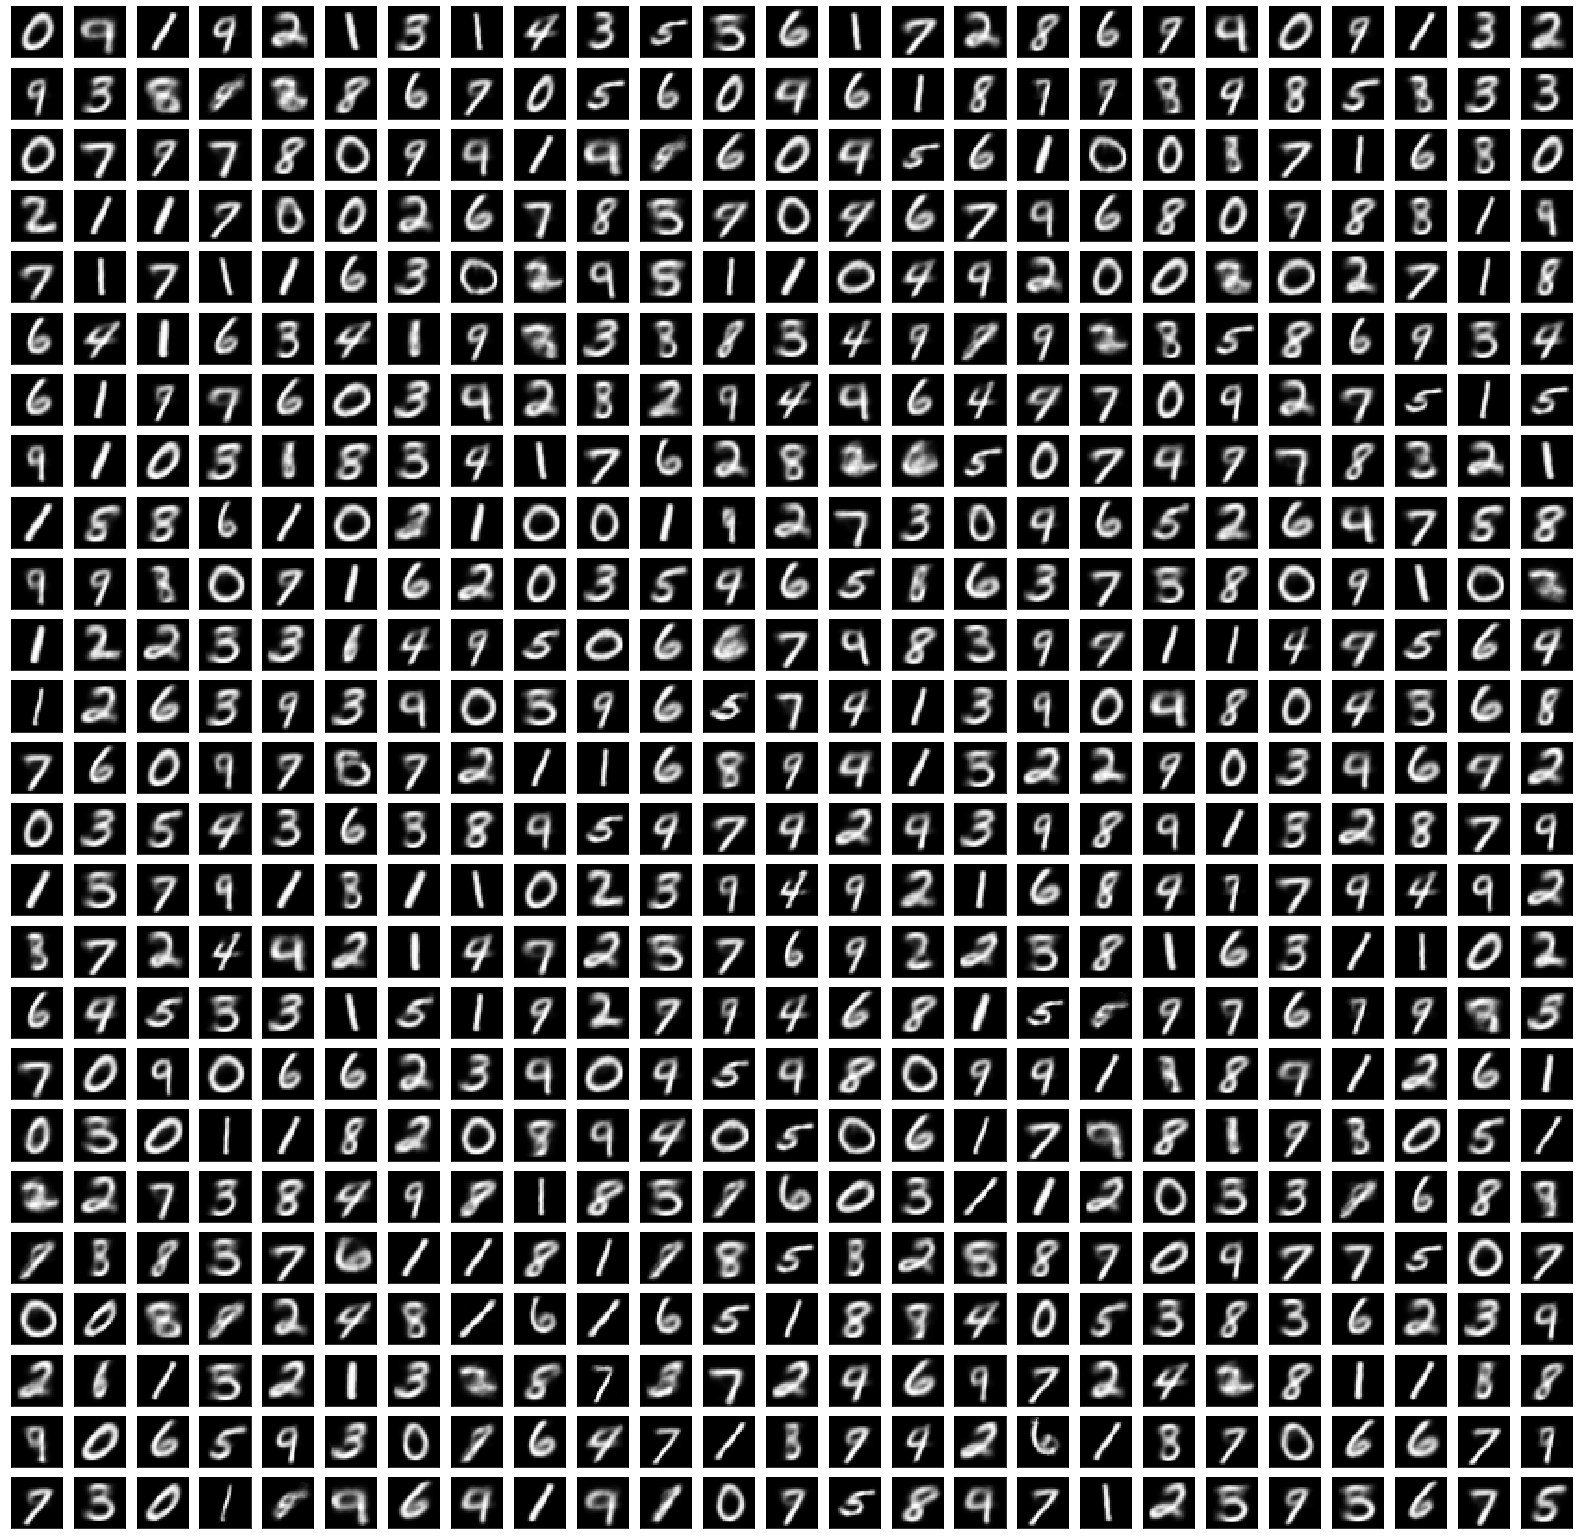

In [11]:
# Visualization of 25 x 25 reconstructed images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(autoencoder.predict(np.expand_dims(x_images[ind].flatten(), 0)).reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        ind+=1

In [12]:
encoder = Model(input_img, encoded)

# Building the decoder
encoded_input = Input(shape=(2,))
#encoded_layer_1 = autoencoder.layers[-4]
encoded_layer_2 = autoencoder.layers[-3]
encoded_layer_3 = autoencoder.layers[-2]
encoded_layer_4 = autoencoder.layers[-1]

#decoder = encoded_layer_1(encoded_input)
decoder = encoded_layer_2(encoded_input)
decoder = encoded_layer_3(decoder)
decoder = encoded_layer_4(decoder)
decoder = Model(encoded_input, decoder)

### 5.4 Visualizing the mapping of the labeled images in the manifold

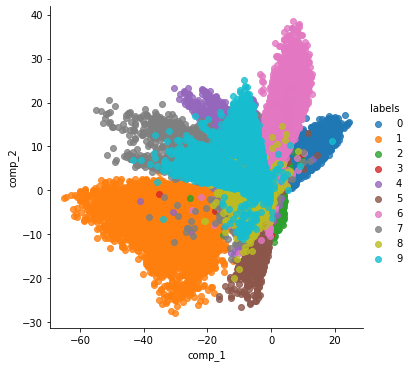

In [13]:
import seaborn as sns

x_flat = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])

x_proj = encoder.predict(x_flat[:60000])
x_proj.shape

proj = pd.DataFrame(x_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_train[:60000]
sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)

### 5.5. Generating new digits by moving along the manifold (latent 2D space)
**Please, adjust the scale whenever necessary.**

### 5.5.1 Moving along a circle

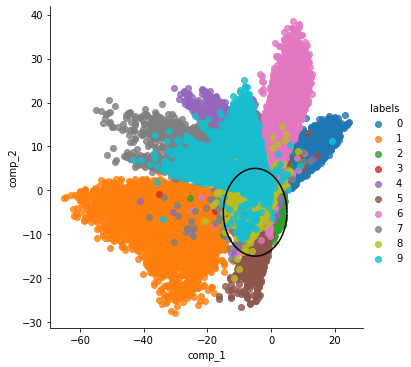

In [14]:
_ = sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [10 * np.cos(2 * np.pi / 100 * i) - 5 for i in range(100)]
all_y = [10 * np.sin(2 * np.pi / 100 * i) - 5 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

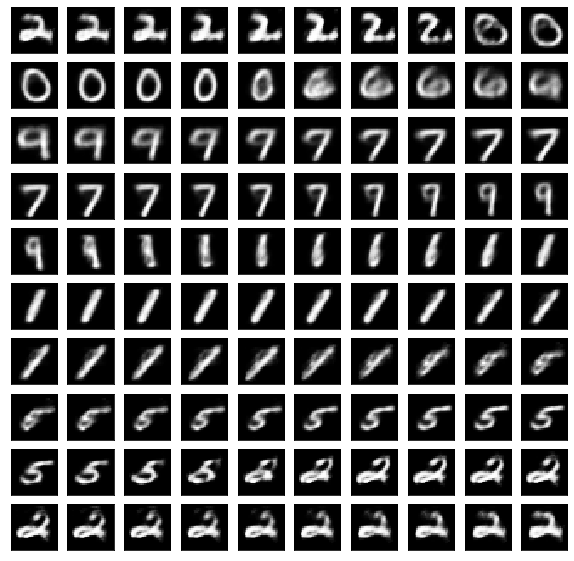

In [15]:
# moving along a circle:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 10 * np.cos(2 * np.pi / 100 * i) - 5
    y = 10 * np.sin(2 * np.pi / 100 * i) - 5
    
    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### 5.5.2 Moving along an ellipse

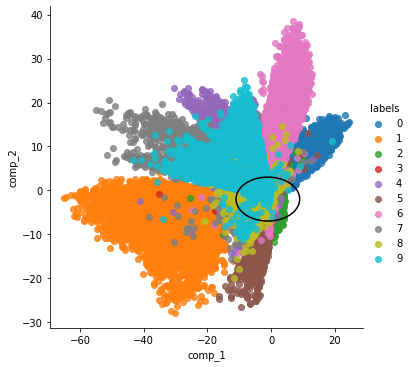

In [16]:
_ = sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [10 * np.cos(2 * np.pi / 100 * i) - 1 for i in range(100)]
all_y = [5 * np.sin(2 * np.pi / 100 * i) - 2 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

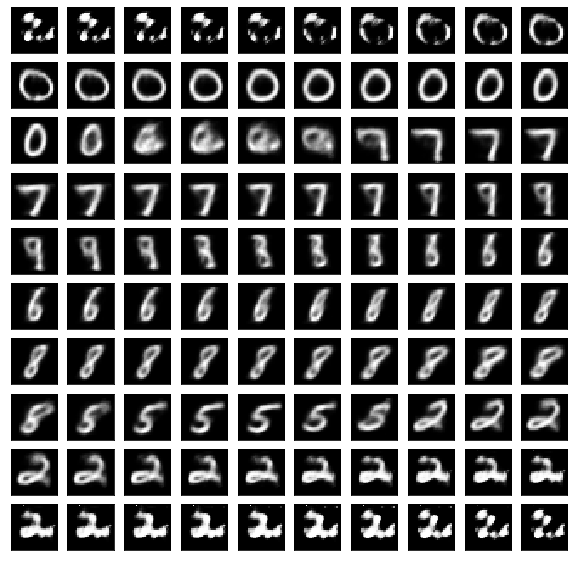

In [17]:
# moving along a elipse:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 10 * np.cos(2 * np.pi / 100 * i) - 1
    y = 5 * np.sin(2 * np.pi / 100 * i) - 2
    
    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### 5.5.3 Moving along a grid

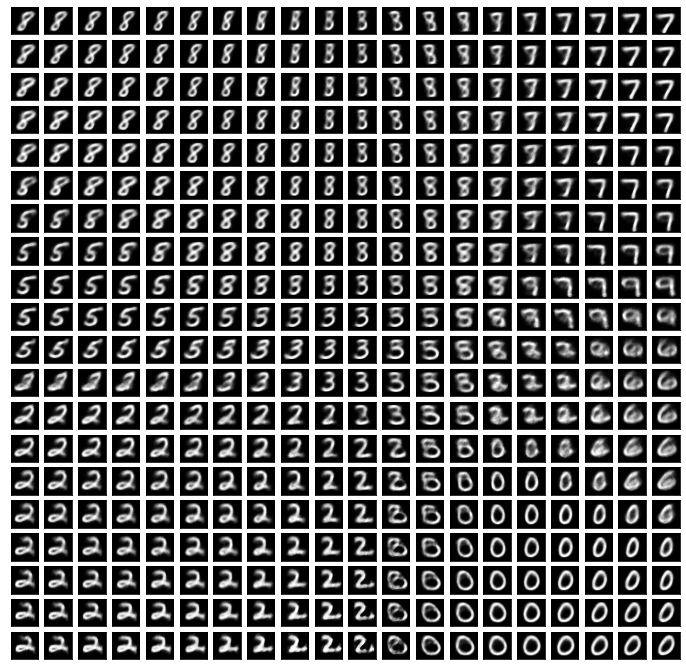

In [18]:
# moving along a grid:
_ = plt.figure(figsize=(12, 12))

for i in range(20):
    for j in range(20):
        
        _ = plt.subplot(20, 20, i * 20 + j + 1)
        
        pt = np.array([[ -6 + 10 * i / 19, -6 + 10 * j / 19]])
        _ = show(decoder.predict(pt).reshape((28, 28)))
        _ = plt.xticks([])
        _ = plt.yticks([])